In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


In [2]:
generate_images = True
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by 30 to 60MB if set to True; size is <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio==1.0.0
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else:
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately
import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
    
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


Using Kaggle kernel. Setting up environment
     |████████████████████████████████| 6.4 MB 4.1 MB/s eta 0:00:01
  Attempting uninstall: mne
    Found existing installation: mne 0.20.0
    Uninstalling mne-0.20.0:
      Successfully uninstalled mne-0.20.0
     |████████████████████████████████| 1.1 MB 4.8 MB/s eta 0:00:01
  Created wheel for pyedflib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=955256 sha256=6b85752233ad8f2f6620b6de760da3c3a5fa16eba7b9f6f796f3ee2e068c462f
  Stored in directory: /root/.cache/pip/wheels/5b/d3/bd/3fdd15982e9999079344857e8ce9fbdc379d2bd8ad974ea414
Successfully built pyedflib
     |████████████████████████████████| 76 kB 2.3 MB/s eta 0:00:011
A    Raw/Healthy Controls
A    Raw/Healthy Controls/h01.edf
A    Raw/Healthy Controls/h02.edf
A    Raw/Healthy Controls/h03.edf
A    Raw/Healthy Controls/h04.edf
A    Raw/Healthy Controls/h05.edf
A    Raw/Healthy Controls/h06.edf
A    Raw/Healthy Controls/h07.edf
A    Raw/Healthy Controls/h08.edf
A    Raw/

Loading BokehJS ...

In [3]:
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [] #[ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'
chans=len(all_channels) - len(excluded_channels)

data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels=excluded_channels, time_window=time_window)


Minimum duration:  740


'Shape of raw data for healthy controls: '

(14, 125001, 19)

'Shape of raw data for schizophrenic patients: '

(12, 125001, 19)

Selecting training  / testing / validation sets randomly from patient data
Splitting data into time windows to improve stability of results
(10, 125001, 19)
(250, 5000, 19)
Shape of X_train:  (450, 5000, 19)
Shape of X_validate:  (100, 5000, 19)
Shape of X_test:  (100, 5000, 19)
Removing outliers by channel
Selected indexes for control group: 
Training:  [4, 7, 13, 2, 9, 6, 3, 1, 0, 5]
Testing:  [11, 10]
Validation:  [8, 12]

Selected indexes for patient group: 
Training:  [9, 5, 1, 7, 10, 0, 3, 4]
Testing:  [2, 8]
Validation:  [11, 6]


In [4]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [10]:
import tensorflow.keras.layers as layers

#https://www.tensorflow.org/guide/keras/rnn

def GRU_RNN(time_steps, nb_features, chans, nb_classes):
    model=tf.keras.Sequential()
    
    # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
    model.add(layers.GRU(33, #256, 
                         input_shape=( time_steps, chans),
                         return_sequences=True))

    model.add(layers.SimpleRNN(33))
    model.add(Dense(3,kernel_initializer='he_uniform',activation='relu'))
    model.add(Dense(nb_classes,activation='softmax'))
    
    return model   


In [11]:
#declare model, optimizer and checkpoint file
gru_model = GRU_RNN(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )
gru_opt_adam = tf.keras.optimizers.Adam(lr=0.00009, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
gru_checkpoint = '/tmp/GRU_RNN_checkpoint.h5'

gru_fitted_model = model_builder.construct_and_run_model(data, gru_model, gru_opt_adam, gru_checkpoint, epochs=200, batch_size=64)####




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5000, 33)          5346      
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 33)                2211      
_________________________________________________________________
dense (Dense)                (None, 3)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 7,667
Trainable params: 7,667
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 100 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.68007, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 49s - loss: 0.6909 - accuracy: 0.5578 - rmse: 0.4995 - val_loss: 0.6801 - val_accuracy

Epoch 32/200

Epoch 00032: val_loss improved from 0.66594 to 0.66548, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 43s - loss: 0.6599 - accuracy: 0.5889 - rmse: 0.4892 - val_loss: 0.6655 - val_accuracy: 0.5900 - val_rmse: 0.4965
Epoch 33/200

Epoch 00033: val_loss improved from 0.66548 to 0.66508, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 43s - loss: 0.6590 - accuracy: 0.5933 - rmse: 0.4730 - val_loss: 0.6651 - val_accuracy: 0.5900 - val_rmse: 0.4964
Epoch 34/200

Epoch 00034: val_loss improved from 0.66508 to 0.66465, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 43s - loss: 0.6581 - accuracy: 0.5933 - rmse: 0.4855 - val_loss: 0.6646 - val_accuracy: 0.5900 - val_rmse: 0.4963
Epoch 35/200

Epoch 00035: val_loss improved from 0.66465 to 0.66417, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 44s - loss: 0.6571 - accuracy: 0.5978 - rmse: 0.4777 - val_loss: 0.6642 - val_accuracy: 0.5900 - val_rmse: 0.4961
Epoch 36/200

Epoch 00036: val_loss improved from 0.

Epoch 67/200

Epoch 00067: val_loss improved from 0.64432 to 0.64346, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.6303 - accuracy: 0.6178 - rmse: 0.4626 - val_loss: 0.6435 - val_accuracy: 0.6800 - val_rmse: 0.4889
Epoch 68/200

Epoch 00068: val_loss improved from 0.64346 to 0.64256, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 40s - loss: 0.6295 - accuracy: 0.6156 - rmse: 0.4570 - val_loss: 0.6426 - val_accuracy: 0.6900 - val_rmse: 0.4887
Epoch 69/200

Epoch 00069: val_loss improved from 0.64256 to 0.64163, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.6286 - accuracy: 0.6200 - rmse: 0.4892 - val_loss: 0.6416 - val_accuracy: 0.6900 - val_rmse: 0.4883
Epoch 70/200

Epoch 00070: val_loss improved from 0.64163 to 0.64074, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.6277 - accuracy: 0.6200 - rmse: 0.4711 - val_loss: 0.6407 - val_accuracy: 0.6900 - val_rmse: 0.4880
Epoch 71/200

Epoch 00071: val_loss improved from 0.

Epoch 102/200

Epoch 00102: val_loss improved from 0.61101 to 0.61008, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5989 - accuracy: 0.7067 - rmse: 0.4711 - val_loss: 0.6101 - val_accuracy: 0.7400 - val_rmse: 0.4737
Epoch 103/200

Epoch 00103: val_loss improved from 0.61008 to 0.60918, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5980 - accuracy: 0.7089 - rmse: 0.4544 - val_loss: 0.6092 - val_accuracy: 0.7400 - val_rmse: 0.4732
Epoch 104/200

Epoch 00104: val_loss improved from 0.60918 to 0.60829, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 42s - loss: 0.5972 - accuracy: 0.7089 - rmse: 0.4768 - val_loss: 0.6083 - val_accuracy: 0.7400 - val_rmse: 0.4727
Epoch 105/200

Epoch 00105: val_loss improved from 0.60829 to 0.60745, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5964 - accuracy: 0.7111 - rmse: 0.4481 - val_loss: 0.6075 - val_accuracy: 0.7400 - val_rmse: 0.4723
Epoch 106/200

Epoch 00106: val_loss improved fr

Epoch 137/200

Epoch 00137: val_loss improved from 0.57587 to 0.57488, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5663 - accuracy: 0.7244 - rmse: 0.4283 - val_loss: 0.5749 - val_accuracy: 0.7400 - val_rmse: 0.4570
Epoch 138/200

Epoch 00138: val_loss improved from 0.57488 to 0.57388, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 40s - loss: 0.5654 - accuracy: 0.7244 - rmse: 0.4330 - val_loss: 0.5739 - val_accuracy: 0.7500 - val_rmse: 0.4565
Epoch 139/200

Epoch 00139: val_loss improved from 0.57388 to 0.57291, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5643 - accuracy: 0.7289 - rmse: 0.4131 - val_loss: 0.5729 - val_accuracy: 0.7500 - val_rmse: 0.4560
Epoch 140/200

Epoch 00140: val_loss improved from 0.57291 to 0.57191, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5634 - accuracy: 0.7267 - rmse: 0.3969 - val_loss: 0.5719 - val_accuracy: 0.7500 - val_rmse: 0.4555
Epoch 141/200

Epoch 00141: val_loss improved fr

Epoch 172/200

Epoch 00172: val_loss improved from 0.54772 to 0.54695, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 40s - loss: 0.5310 - accuracy: 0.7889 - rmse: 0.4011 - val_loss: 0.5469 - val_accuracy: 0.7600 - val_rmse: 0.4416
Epoch 173/200

Epoch 00173: val_loss improved from 0.54695 to 0.54619, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5300 - accuracy: 0.7844 - rmse: 0.4272 - val_loss: 0.5462 - val_accuracy: 0.7700 - val_rmse: 0.4414
Epoch 174/200

Epoch 00174: val_loss improved from 0.54619 to 0.54550, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 41s - loss: 0.5291 - accuracy: 0.7822 - rmse: 0.4023 - val_loss: 0.5455 - val_accuracy: 0.7700 - val_rmse: 0.4412
Epoch 175/200

Epoch 00175: val_loss improved from 0.54550 to 0.54485, saving model to /tmp/GRU_RNN_checkpoint.h5
450/450 - 40s - loss: 0.5282 - accuracy: 0.7778 - rmse: 0.4101 - val_loss: 0.5449 - val_accuracy: 0.7700 - val_rmse: 0.4410
Epoch 176/200

Epoch 00176: val_loss improved fr

NameError: name 'print_model_metrics' is not defined

Diagrammed History of Model Metrics


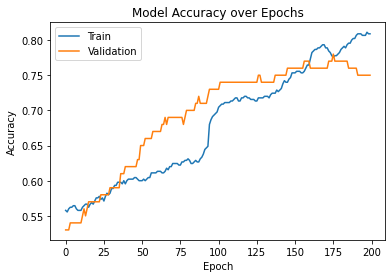

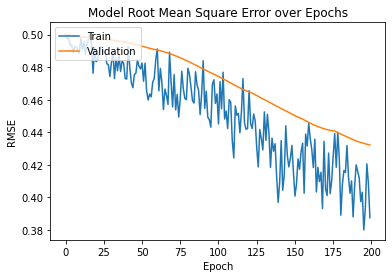

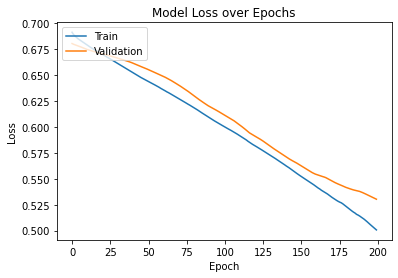

In [13]:
model_builder.print_model_metrics(gru_fitted_model, acc_key)


In [14]:
!pip freeze

absl-py==0.9.0
affine==2.3.0
aiohttp==3.6.2
alabaster==0.7.12
albumentations==0.4.5
alembic==1.4.2
allennlp==0.9.0
altair==4.0.1
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
annoy==1.16.3
appdirs==1.4.3
argh==0.26.2
arrow==0.15.5
arviz==0.7.0
asn1crypto==1.3.0
astor==0.8.1
astroid==2.3.3
astropy==3.2.3
async-timeout==3.0.1
atomicwrites==1.3.0
attr==0.3.1
attrs==19.3.0
audioread==2.1.8
autopep8==1.4.4
Babel==2.8.0
backcall==0.1.0
backports.functools-lru-cache==1.6.1
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
Baker==1.3
basemap==1.2.1
bayesian-optimization==1.1.0
bayespy==0.5.19
bcolz==1.2.1
beautifulsoup4==4.8.2
biopython==1.76
bitarray==1.2.1
bkcharts==0.2
bleach==3.1.0
blis==0.4.1
bokeh==2.0.1
Boruta==0.3
boto==2.49.0
boto3==1.12.32
botocore==1.15.32
Bottleneck==1.3.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplot==0.1

In [15]:
from platform import python_version

print(python_version())

3.6.6
